In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import fitz
from fitz import Rect
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances

from pdf_scraper.doc_utils     import open_exam, get_doc_line_df, identify_section_headers, identify_text_headers, get_path_from_doc
from pdf_scraper.doc_utils     import identify_footers, identify_instructions, identify_subtitles, identify_subsubtitles
from pdf_scraper.line_utils    import clean_line_df, get_category_boxes, get_df_bbox
from pdf_scraper.doc_utils     import get_images, filter_images, assign_in_image_captions, identify_vertical_captions
from pdf_scraper.doc_utils     import enrich_doc_df_with_images
from pdf_scraper.clustering.cluster_utils import find_y0_dL, split_cluster, hdbscan
from pdf_scraper.general_utils import df_bbox_dist, df_bbox_next_row_dist
from pdf_scraper.image_utils   import get_bboxed_page_image

pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_colwidth", 200)

In [3]:
year=2019
doc    = open_exam(year, "english", "al",1)
df     = get_doc_line_df(doc)

images = get_images(doc)
images = filter_images(images)
assign_in_image_captions(df,images)

doc_width     = doc[0].rect.width
middle        = doc_width/2
standard_font = df.mode_font.mode()[0]
median_font   = df.font_size.median()


df = clean_line_df(df)
identify_footers(df)
identify_instructions(df)
identify_section_headers(df)
identify_text_headers(df, doc_width)
identify_subtitles(df, doc_width)
identify_subsubtitles(df,doc_width)


for image in images:
    if image["page"] <2 or image["page"] >8:
        continue
    identify_vertical_captions(df, image)

page: 2


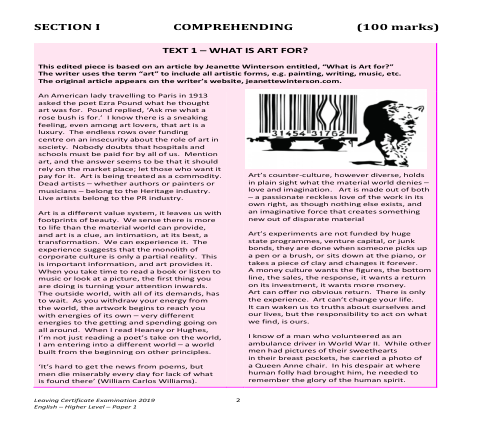

In [4]:
page = np.unique(df[df.caption2==1].page)[0]
page_df = df.loc[df.page==page, ["text", 'x0', 'y0', 'x1', 'y1', "page","w"]].copy()
page_images = [image for image in images if image["page"]==page]
page_df = enrich_doc_df_with_images(page_df,page_images)
page_df["dL"] = page_df.y0.diff()

doc_page = doc[int(page-1)]
pix = doc_page.get_pixmap(matrix=fitz.Matrix(0.8, 0.5))  # scale=2 for higher resolution
img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
print(f"page: {page}")
display(img)

## Separate y0 and x0 scans 

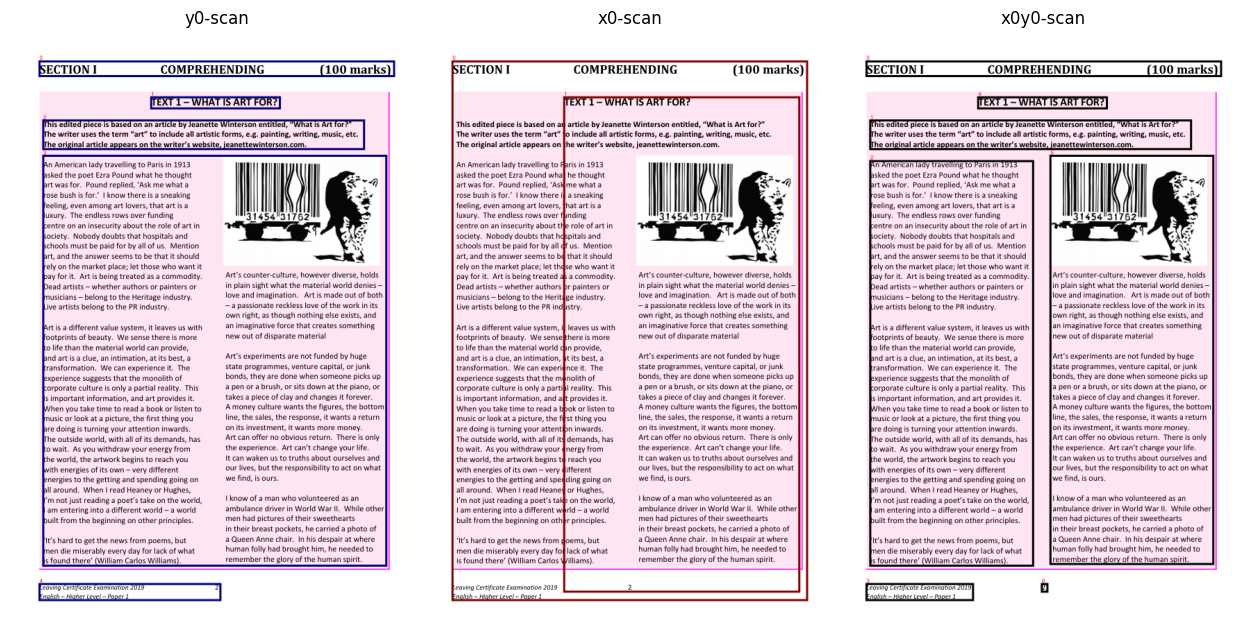

In [5]:
eps_y0 = dL_y0 = find_y0_dL(page_df)*1.15
scan_y = DBSCAN(eps=dL_y0, min_samples=1)
page_df["y_cluster"]= scan_y.fit_predict(page_df[["y0"]])


median_w = page_df.w.dropna().map(round).median()
eps_x0    = median_w*0.5
scan_x = DBSCAN(eps=eps_x0, min_samples=1)
page_df["x_cluster"]= scan_x.fit_predict(page_df[["x0"]])

rectangies_y = get_category_boxes(page_df, 'y_cluster')
y_img = get_bboxed_page_image(doc, page, rectangies_y, color=(0,0,0.5), labels=np.unique(page_df.y_cluster) )


rectangies_x = get_category_boxes(page_df, 'x_cluster')
x_img = get_bboxed_page_image(doc, page, rectangies_x,color=(0.5,0,0.0),labels = np.unique(scan_x.labels_))

# Join lcluster labels
page_df["xy_cluster"] = page_df.groupby(["x_cluster", "y_cluster"]).ngroup()
rectangies_xy = get_category_boxes(page_df, 'xy_cluster')
xy_img = get_bboxed_page_image(doc, page, rectangies_xy,color=(0.0,0,0.0),labels=np.unique(page_df.xy_cluster))

fig, axes = plt.subplots(1,3,figsize=(16,8))

axes[0].imshow(y_img); axes[0].axis("off"); axes[0].set_title("y0-scan");
axes[1].imshow(x_img); axes[1].axis("off"); axes[1].set_title("x0-scan")
axes[2].imshow(xy_img); axes[2].axis("off"); axes[2].set_title("x0y0-scan")
plt.subplots_adjust(wspace=0.0)


- This is an improved clustering. But we notice that not all pagraphs are separated in y
  - Do another y clustering within each group.
  - The issue is that, when looking only at y, the existence of "A library in the middle" to the right of the paragraph ending in "Eames lamp" gives a false
    impression of contiguity.

# Hierarchical alternating scan till stability

In [6]:
median_dy0 = find_y0_dL(page_df)
median_w   = page_df.w.median()
eps_y0     = median_dy0*1.15
eps_x0     = median_w*0.5

rectangs, labia = hdbscan(page_df, 100, eps_x0, eps_y0, "euclidean",False)
imgs = [get_bboxed_page_image(doc, page, rectangies,color=(0.0,0,0.0), labels=labelos) for rectangies, labelos in zip(rectangs, labia)]
display(imgs[-1])

# Scan using bbox distances

# Loop over years

In [ ]:
year=2001; page = 2 
def check_year_page(year, page, x_scale, y_scale):
    doc    = open_exam(year, "english", "al",1)
    df     = get_doc_line_df(doc)
    
    images = get_images(doc)
    images = filter_images(images)
    assign_in_image_captions(df,images)
    
    df = clean_line_df(df)
    for image in images:
        if image["page"] <2 or image["page"] >8:
            continue
        identify_vertical_captions(df, image)
    page_images = [image for image in images if image["page"]==page]
    
    page_df = df.loc[df.page==page, ["text", 'x0', 'y0', 'x1', 'y1', "page","w"]].copy()
    page_df = enrich_doc_df_with_images(page_df,page_images)
    
    
    page_df["dL_e2e"] = df_bbox_next_row_dist(page_df.y0, page_df.y1, page_df.y0.shift(-1), page_df.y1.shift(-1) )
    dLs = page_df.dL_e2e.dropna()
    dL_median = dLs[dLs!=0].median()
    
    eps_y = dL_median * y_scale
    
    middle = (page_df.x0.min() + page_df.x1.max())/2
    left  = page_df[page_df.x1 < middle +5 ]
    right = page_df[page_df.x0 > middle -5 ]
    
    left_right_dist  = pairwise_distances(left[["x0","x1"]], right[["x0","x1"]], metric=df_bbox_dist)
    mask = (left_right_dist!=0)                 # Exclude overlapping lines
    eps_x = x_scale * left_right_dist[mask].min()

    # This is for the case were there is document length lines on the same page as the dual columns.
    # These will cause the min end to end difference to be 0. 10 is a good estimate for an appropriate x distance
    # found by trial and error.
    #eps_x = 10 if eps_x == 0 else eps_x   
    
    
    print(f"eps_x: {eps_x:8.2f} eps_y: {eps_y:8.2f}")
    
    rectangs, labia = hdbscan(page_df, 100, eps_x, eps_y, df_bbox_dist,False)
    imgs = [get_bboxed_page_image(doc, page, rectangies,color=(0.0,0,0.0), labels=labelos) for rectangies, labelos in zip(rectangs, labia)]
    display(imgs[-1])
#check_year_page(2023, 6, (2.0/3.0), 1.10)

2001 2
eps_x: 17.762044270833332 eps_y: 15.601021575927735


2002 6
eps_x: 13.521199544270832 eps_y: 0.5675022125244141


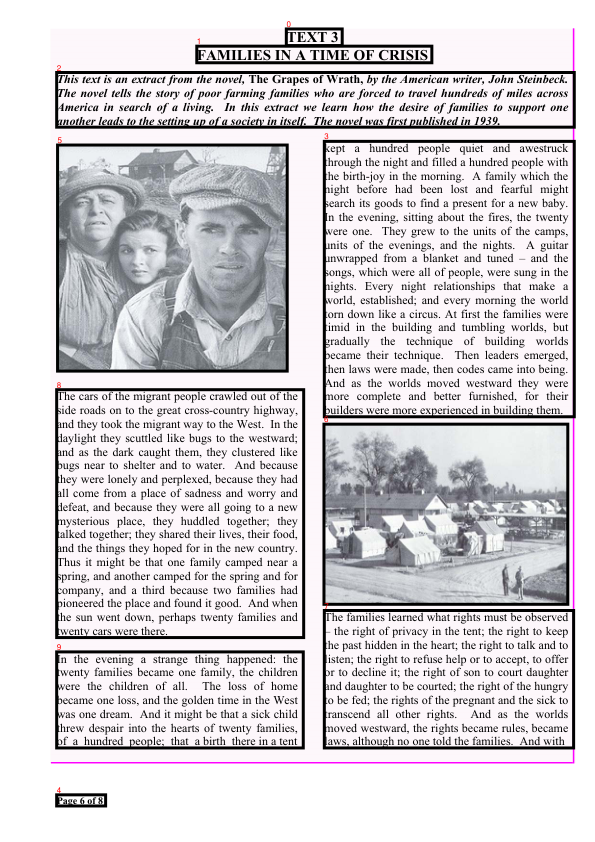

2010 7
eps_x: 9.400004069010416 eps_y: 13.14054870605469


2011 2
eps_x: 3.5000031789143877 eps_y: 0.5675903320312501


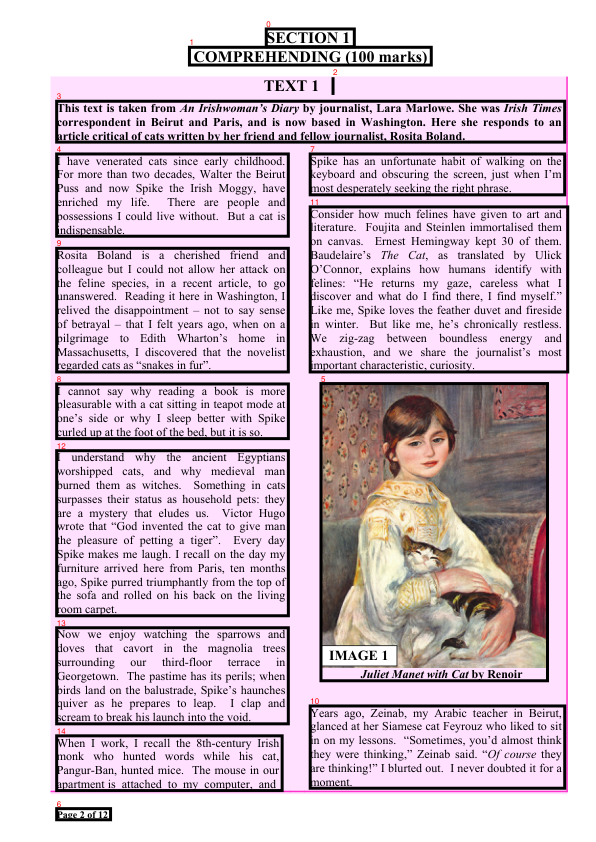

2011 3
eps_x: 12.74078369140625 eps_y: 0.5675903320312501


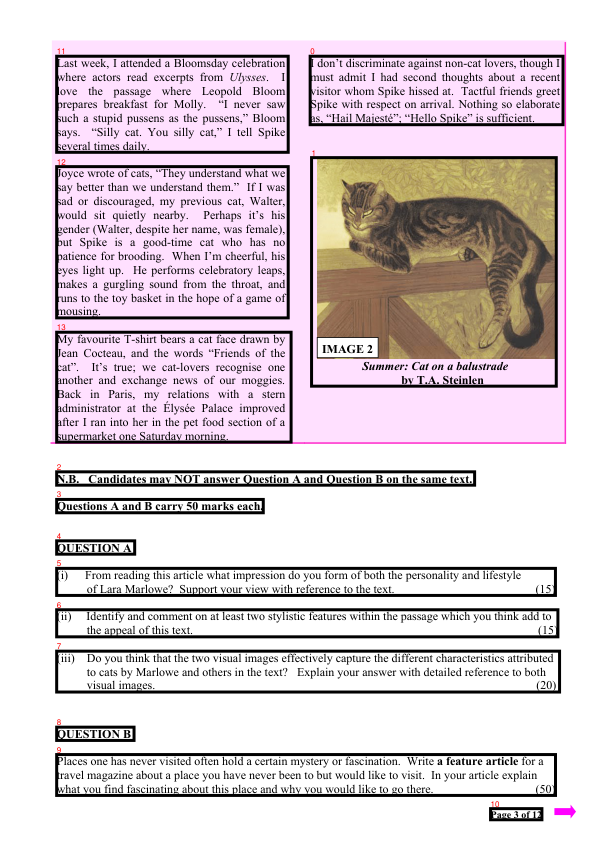

2012 4
eps_x: 15.7557373046875 eps_y: 0.5675903320312501


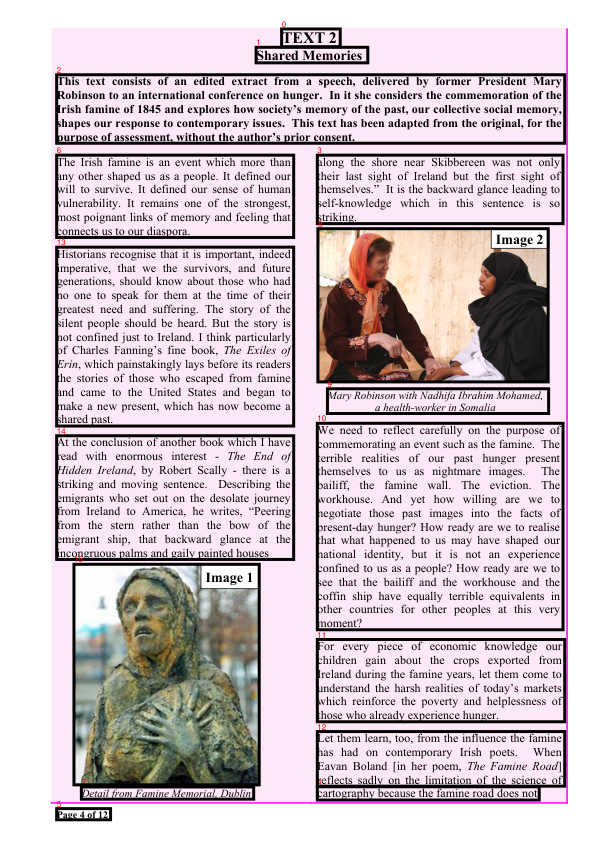

2012 5
eps_x: 14.638387044270832 eps_y: 0.5675903320312501


2013 4
eps_x: 14.0 eps_y: 0.5676239013671875


2013 6
eps_x: 13.059163411458332 eps_y: 0.5675903320312501


2013 7
eps_x: 12.515218098958332 eps_y: 0.5676239013671875


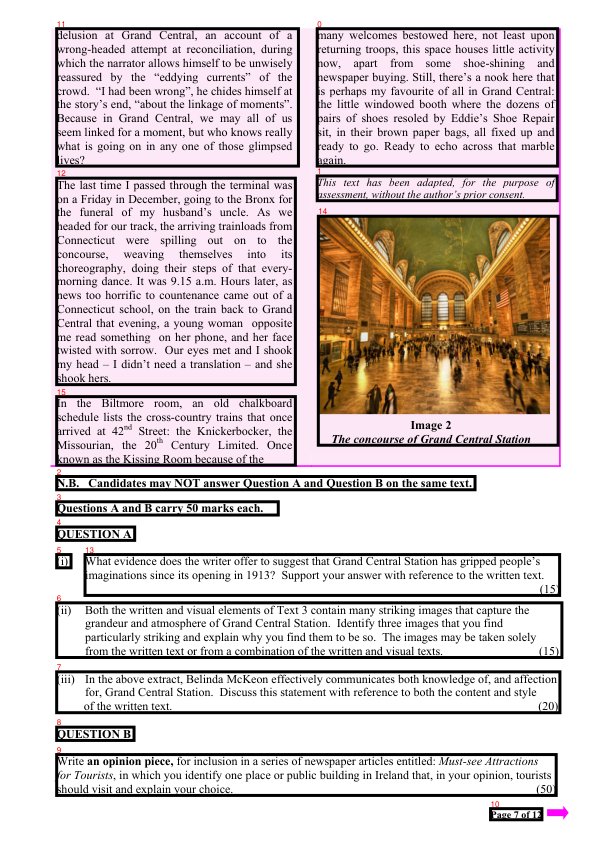

2014 3
eps_x: 13.221598307291666 eps_y: 0.5676364898681641


2019 2
eps_x: 8.352823893229166 eps_y: 0.2640228271484375


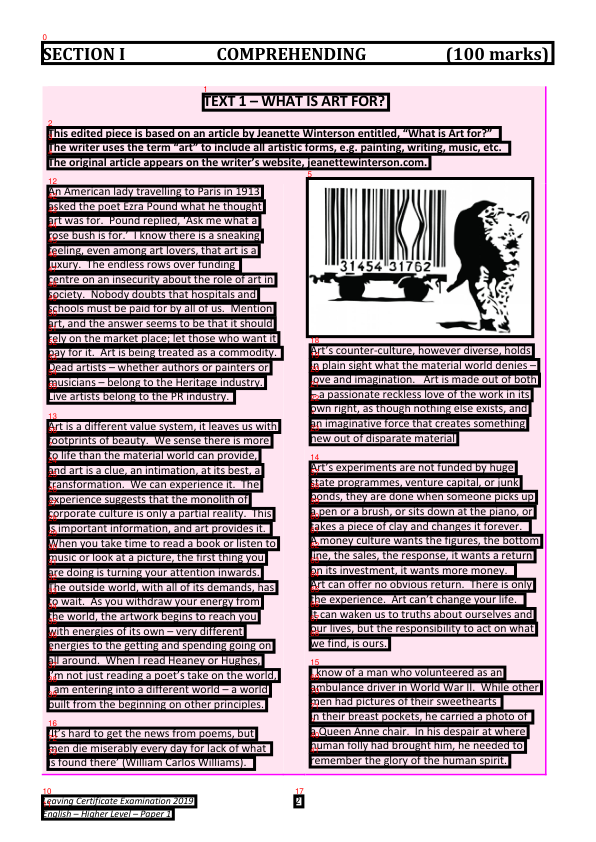

2023 6
eps_x: 4.380818684895833 eps_y: 2.903982543945313


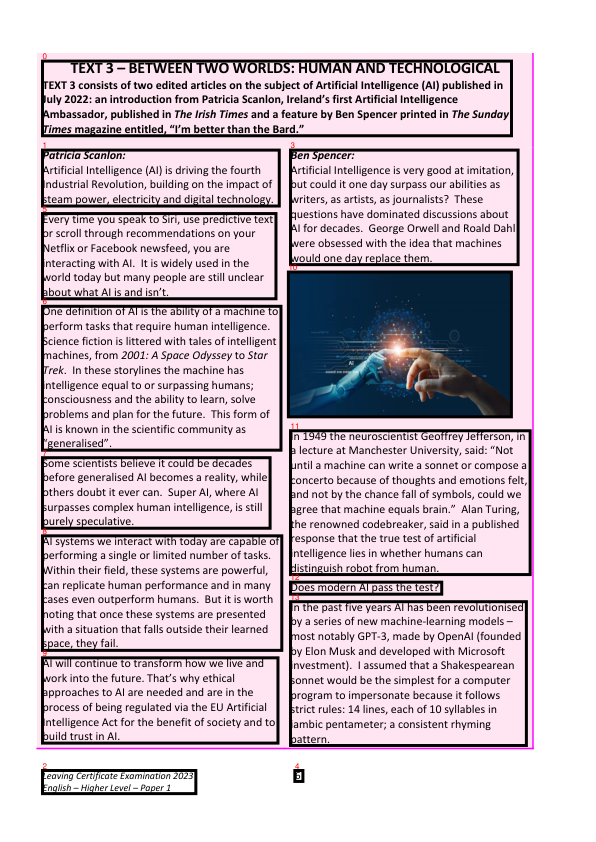

2024 3
eps_x: 2.86492919921875 eps_y: 2.90401611328125


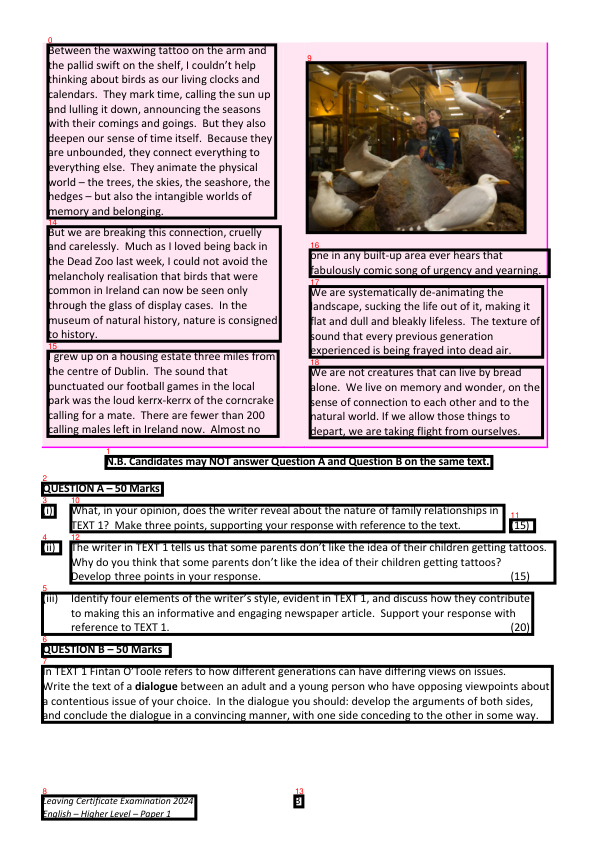

In [8]:
for year, page in [(2001, 2),(2002, 6),(2010, 7),(2011, 2),(2011, 3),(2012, 4),(2012, 5),
                   (2013, 4),(2013, 6),(2013, 7),(2014, 3),(2019,2) ,(2023, 6),(2024, 3)]:
    print(year, page)
    check_year_page(year, page, 2/3, 1.1)